### Layerwise Relevance Propogation

This notebook shows how to perform layerwise relevance propogation on a pretrained CNN network. 

First, load the required libraries.

In [ ]:
import tensorflow as tf
import pandas as pd
import xarray as xr
from glob import glob
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import cartopy.crs as ccrs
import pickle
%pylab inline

## LayerwiseRelevancePropogation class

This class will do the LRP on a pretrained model. Right now, this class supports:

    * Conv2D, Dense, Add, BatchNormalization, and Pooling layers
    * Multiple branches within the neural network and multiple inputs
    

In [2]:
class LayerwiseRelevancePropogation():
    def __init__(self, model):
        self.model = model
        self.epsilon = 1e-5
        # Count the number of input layers --> Number of CNN networks
        self.no_inputs = 0
        self.pooling_type = "max"
        for x in model.layers:
            if 'input_' in x.name:
                self.no_inputs += 1
        self.alpha = 3
        self.beta = 1
        
    def backprop_dense(self, x, w, r):
        w_pos = tf.maximum(w, tf.zeros_like(w))
        z = tf.matmul(x, w_pos) + self.epsilon
        s = r / z
        c_p = tf.matmul(s, tf.transpose(w_pos))

        w_neg = tf.minimum(w, tf.zeros_like(w))
        z = tf.matmul(x, w_neg) + self.epsilon
        s = r / z
        c_n = tf.matmul(s, tf.transpose(w_neg))
        return (self.alpha * c_p + self.beta * c_n) * x

    def backprop_flatten(self, x, r):
        return tf.reshape(r, tf.shape(x))
    
    def relprop_add(self, x, r):
        z = tf.add_n(x) + self.epsilon
        s = r / z
        c = s
        return c * x
        
    def relprop_batchnorm(self, x, r, w):
        gamma = w[0]
        beta = w[1]
        mmean = w[2]
        mvar = w[3]
        z = tf.nn.batch_normalization(x, mmean, mvar, beta, gamma, self.epsilon) + self.epsilon
        s = r / z
        with tf.GradientTape() as g:
            g.watch(s)
            R = tf.nn.batch_normalization(s, mmean, mvar, beta, gamma, self.epsilon)
        c = g.gradient(R, s)
        return c * x
     
    def relprop_conv(self, x, r, w, strides=(1, 1, 1, 1), padding='SAME'):
        if len(strides) == 2:
            strides = (1, strides[0], strides[1], 1)
        w_pos = tf.maximum(w, 0.0)
        z = tf.nn.conv2d(x, w_pos, strides, padding) + self.epsilon
        s = r / z
        c_p = tf.compat.v1.nn.conv2d_backprop_input(tf.shape(x), w_pos, s, strides, padding)

        w_neg = tf.minimum(w, 0.0)
        z = tf.nn.conv2d(x, w_neg, strides, padding) + self.epsilon
        s = r / z
        c_n = tf.compat.v1.nn.conv2d_backprop_input(tf.shape(x), w_neg, s, strides, padding)

        return (self.alpha * c_p + self.beta * c_n) * x

    def relprop_pool(self, x, r, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1), padding='SAME'):
        if len(strides) == 2:
            strides = (1, strides[0], strides[1], 1)
        if len(ksize) == 2:
            ksize = (1, ksize[0], ksize[1], 1)
        if self.pooling_type == 'avg':
            z = tf.nn.avg_pool(x, ksize, strides, padding) + self.epsilon
            s = r / z
            with tf.GradientTape() as g:
                g.watch(s)
                R = tf.nn.avg_pool(s, ksize, strides, padding)
            c = g.gradient(R, s)
        elif self.pooling_type == 'max':
            z = tf.nn.max_pool(x, ksize, strides, padding) + self.epsilon
            s = r / z
            c = tf.raw_ops.MaxPoolGradV2(orig_input=x, orig_output=z, grad=s, ksize=ksize, strides=strides, padding=padding)
        else:
            raise Exception('Error: no such unpooling operation.')
        return c * x

    def calc_relevance(self, inputs, outputs):
        if len(list(inputs.keys())) != self.no_inputs:
            raise InputError("Not enough inputs for model. Need %d inputs" % self.no_inputs)
        cur_layer = self.model.layers[-1]
        cur_relevance = outputs
        output_relevances = {}
        
        output_relevances["output"] = tf.constant(outputs.astype(np.float32))
        # Evaluate x for each layer:
        x_layers = inputs.copy()
        for my_layer in self.model.layers:
            if not isinstance(my_layer.input, list):
                x_layers[my_layer.name.split("/")[0]] = my_layer(x_layers[my_layer.input.name.split("/")[0]])
            else:
                x_layers[my_layer.name.split("/")[0]] = my_layer(list(x_layers[y.name.split("/")[0]] for y in my_layer.input))
                
        x_layers["output"] = tf.constant(outputs.astype(np.float32))
        # Backpropgate relevances
        for my_layer in self.model.layers[-1:0:-1]:
            if not isinstance(my_layer.input, list):
                inp_layer_name = my_layer.input.name.split("/")[0]
            
            if 'add' in my_layer.name:
                x_list = [x_layers[g.name.split("/")[0]] for g in my_layer.input]
                out_layer_name = my_layer._outbound_nodes[0].outputs.name.split("/")[0]
                add_relevances = tf.split(self.relprop_add(
                    x_list, output_relevances[out_layer_name]), self.no_inputs, axis=0)
                continue
            

            inp_layer = self.model.get_layer(inp_layer_name)
            try:
                out_layer_name = my_layer._outbound_nodes[0].outputs.name.split("/")[0]
            except IndexError:
                out_layer_name = "output"
            
            if 'dense' in my_layer.name or 'class' in my_layer.name:
                output_relevances[my_layer.name.split("/")[0]] = self.backprop_dense(
                    x_layers[inp_layer_name],
                    my_layer.trainable_weights[0],
                    output_relevances[out_layer_name])
            elif 'conv2d' in my_layer.name:
                
                output_relevances[my_layer.name.split("/")[0]] = self.relprop_conv(
                    x_layers[inp_layer_name],
                    output_relevances[out_layer_name],
                    my_layer.trainable_weights[0], 
                    strides=my_layer.strides, 
                    padding=my_layer.padding.upper())
            elif 'batch_normalization' in my_layer.name:
                output_relevances[my_layer.name.split("/")[0]] = self.relprop_batchnorm(
                        x_layers[inp_layer_name], 
                        output_relevances[out_layer_name],
                        my_layer.trainable_weights[0])
            elif 'flatten' in my_layer.name:
                name = my_layer.name.split("/")[0]
                if name[-1] == "n":
                    count = 0
                else:
                    count = int(name.split("_")[1])
                output_relevances[my_layer.name.split("/")[0]] = self.backprop_flatten(
                    x_layers[inp_layer_name],
                    add_relevances[count])
            elif 'max_pooling2d' in my_layer.name:
                output_relevances[my_layer.name.split("/")[0]] = self.relprop_pool(
                    x_layers[inp_layer_name],
                    output_relevances[out_layer_name], my_layer.pool_size,
                    my_layer.strides, my_layer.padding.upper())
            elif 'input' in my_layer.name:
                output_relevances[my_layer.name] = output_relevances[out_layer_name]
            
        return output_relevances

# Loading the input model

Here, we load the input model that we are going to perform the relevance calculations on. We will use the EPA AQI classifier model from earlier on in order to do so.

In [48]:
hour = 72
my_model = tf.keras.models.load_model('/lcrc/group/earthscience/rjackson/opencrums/models/classifier')
my_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_SSMASS (InputLayer)      [(None, 20, 32, 1)]  0           []                               
                                                                                                  
 input_SSFLUXU (InputLayer)     [(None, 20, 32, 1)]  0           []                               
                                                                                                  
 input_SSFLUXV (InputLayer)     [(None, 20, 32, 1)]  0           []                               
                                                                                                  
 input_SO4MASS (InputLayer)     [(None, 20, 32, 1)]  0           []                               
                                                                                              

## Load the input data

This code will first load the epa air now .csv data into the air_now_df pandas DataFrame.  Then, the code will load the MERRA2 data in the specified path. Note: the MERRA2 data are preprocessed to include only the relevant domain of interest in order to save training time and memory.

In [49]:
air_now_data = glob('/lcrc/group/earthscience/rjackson/epa_air_now/*.csv')
air_now_df = pd.concat(map(pd.read_csv, air_now_data))
air_now_df['datetime'] = pd.to_datetime(air_now_df['DateObserved'] + ' 00:00:00')
air_now_df = air_now_df.set_index('datetime')
air_now_df = air_now_df.sort_index()
print(air_now_df['CategoryNumber'].values.min())

batch_size = 16

def get_air_now_label(time):
    if np.min(np.abs((air_now_df.index - time))) > timedelta(days=1):
        return np.nan
    ind = np.argmin(np.abs(air_now_df.index - time))
    return air_now_df['CategoryNumber'].values[ind]

def load_data(species):
    ds = xr.open_mfdataset('/lcrc/group/earthscience/rjackson/MERRA2/hou_reduced/%sCMASS*.nc' % species).sortby('time')
    print(ds)
    times = np.array(list(map(pd.to_datetime, ds.time.values)))
    x = ds["%sCMASS" % species].values
    old_shape = x.shape
    scaler = StandardScaler()
    scaler.fit(np.reshape(x, (old_shape[0], old_shape[1] * old_shape[2])))
    x = scaler.transform(
            np.reshape(x, (old_shape[0], old_shape[1] * old_shape[2])))
    x = np.reshape(x, old_shape)
    inputs = np.zeros((old_shape[0], old_shape[1], old_shape[2], 3))
    inputs[:, :, :, 0] = x
    ds.close()
    if species == "SO4" or species == "DMS" or species == "SO2":
       inp = "SU"
    else:
       inp = species
    ds = xr.open_mfdataset('/lcrc/group/earthscience/rjackson/MERRA2/hou_reduced/%sFLUXU*.nc' % inp).sortby('time')
    x2 = ds["%sFLUXU" % inp].values
    scaler = StandardScaler()
    scaler.fit(np.reshape(x2, (old_shape[0], old_shape[1] * old_shape[2])))
    x2 = scaler.transform(
            np.reshape(x2, (old_shape[0], old_shape[1] * old_shape[2])))
    x2 = np.reshape(x2, old_shape)
    inputs[:, :, :, 1] = x2
    ds.close()
    ds = xr.open_mfdataset('/lcrc/group/earthscience/rjackson/MERRA2/hou_reduced/%sFLUXV*.nc' % inp).sortby('time')
    x2 = ds["%sFLUXV" % inp].values
    scaler = StandardScaler()
    scaler.fit(np.reshape(x2, (old_shape[0], old_shape[1] * old_shape[2])))
    x2 = scaler.transform(
            np.reshape(x2, (old_shape[0], old_shape[1] * old_shape[2])))
    x2 = np.reshape(x2, old_shape)
    inputs[:, :, :, 2] = x2
    classification = np.array(list(map(get_air_now_label, times)))
    where_valid = np.isfinite(classification)
    inputs = inputs[where_valid, :, :, :]
    classification = classification[where_valid] - 1
    times = times[where_valid]
    if hour > 0:
        classification = classification[hour:]
        inputs = inputs[:(-hour), :, : :]
        times = times[hour:]
    print(times.shape, classification.shape)
    y = np.concatenate([tf.one_hot(classification, 5).numpy(), times[:, np.newaxis]], axis=1)
    shape = inputs.shape
    x_dataset_train = {'input_%sMASS' % species: inputs[:, :, :, 0],
            'input_%sFLUXU' % inp: inputs[:, :, :, 1],
            'input_%sFLUXV' % inp: inputs[:, :, :, 2]}

    return x_dataset_train, y[:,:5], shape, y[:,5]

x_ds_train = {}
x_ds_test = {}
y_train = []
y_test = []
species_list = ['SS', 'SO4', 'SO2', 'OC','DU', 'DMS', 'BC']
for species in species_list:
    x_ds_train1, y_train, shape, t_train = load_data(species)
    x_ds_train.update(x_ds_train1)

for key in x_ds_train.keys():
    x_ds_train[key] = x_ds_train[key][:, :, :, np.newaxis]


1
<xarray.Dataset>
Dimensions:    (lon: 32, lat: 20, time: 90744)
Coordinates:
  * lon        (lon) float64 -105.0 -104.4 -103.8 ... -86.88 -86.25 -85.62
  * lat        (lat) float64 25.0 25.5 26.0 26.5 27.0 ... 33.0 33.5 34.0 34.5
  * time       (time) datetime64[ns] 2010-01-01T00:30:00 ... 2020-05-08T23:30:00
Data variables:
    SSCMASS    (time, lat, lon) float32 dask.array<chunksize=(8760, 20, 32), meta=np.ndarray>
    SSCMASS25  (time, lat, lon) float32 dask.array<chunksize=(8760, 20, 32), meta=np.ndarray>
(64560,) (64560,)
<xarray.Dataset>
Dimensions:   (lon: 32, lat: 20, time: 90744)
Coordinates:
  * lon       (lon) float64 -105.0 -104.4 -103.8 -103.1 ... -86.88 -86.25 -85.62
  * lat       (lat) float64 25.0 25.5 26.0 26.5 27.0 ... 33.0 33.5 34.0 34.5
  * time      (time) datetime64[ns] 2010-01-01T00:30:00 ... 2020-05-08T23:30:00
Data variables:
    SO4CMASS  (time, lat, lon) float32 dask.array<chunksize=(8760, 20, 32), meta=np.ndarray>
(64560,) (64560,)
<xarray.Dataset>
Dimensi

## Generate model predictions

Use the keras .predict to generate predictions on a set of test data.

In [50]:
y_predict = my_model.predict(x_ds_test)

In [51]:
y_predicts = y_predict.argmax(axis=1)
y_tests = y_test.argmax(axis=1)
matrix = confusion_matrix(y_predicts, y_tests)

## Test model accuracy

Generate a confusion matrix showing the predicted vs actual AQI values. We want to check that the confusion matrix shows that the model can accurately predict AQI before performing the layerwise relevance propogation to ensure that the variable relevances are going towards accurate predictions.

/tmp/ipykernel_3657824/1294337932.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', 'Good', 'Moderate', 'Unhealthy Sens.', 'Unhealthy', 'Hazardous'])
/tmp/ipykernel_3657824/1294337932.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['', 'Good', 'Moderate', 'Unhealthy Sens.', 'Unhealthy', 'Hazardous'])


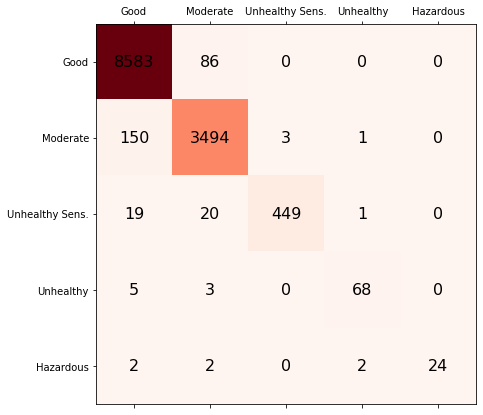

In [52]:
#matrix[matrix == 0] = np.nan
fig = plt.figure(figsize=(7,7))
ax = plt.axes()
ax.matshow(matrix, cmap='Reds')
for (i, j), z in np.ndenumerate(matrix):
    ax.text(j, i, '{:d}'.format(int(z)), ha='center', va='center', color='k', fontsize=16)
ax.set_xticklabels(['', 'Good', 'Moderate', 'Unhealthy Sens.', 'Unhealthy', 'Hazardous'])
ax.set_yticklabels(['', 'Good', 'Moderate', 'Unhealthy Sens.', 'Unhealthy', 'Hazardous'])
fig.savefig('confusion_matrix_aqi_%dhr.png' % hour)

## Generate all of the relevances

These next two code blocks will generate the relevance information. The relevance dictionaries are stored in pickle files that contain the dictionary of relevances for each of the input variables and model layers as well as the time of each sample.

In [53]:
def slice_input_ds(x: dict, y, t, start, end):
    x_new = {}
    for key in x.keys():
        x_new[key] = x[key][start:end, :, :, :].copy()
    y_new = y[start:end, :].copy()
    t_test = t[start:end].copy()
    return x_new, y_new, t_test

In [54]:
lrp = LayerwiseRelevancePropogation(my_model)
for i in range(0, y_test.shape[0], 100):
    print(i + 100)
    x_slice, y_slice, t_slice = slice_input_ds(x_ds_train, y_train, t_train, i, i + 100)
    relevance = lrp.calc_relevance(x_slice, y_slice)
    relevance['time'] = t_slice
    with open('relevance%d-%shr.pickle' % (i, hour), mode='wb') as f:
        pickle.dump(relevance, f)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000


In [21]:
relevance.keys()

dict_keys(['outputs', 'class', 'batch_normalization_36', 'dense_2', 'batch_normalization_35', 'dense_1', 'batch_normalization_34', 'dense', 'flatten_16', 'flatten_15', 'flatten_14', 'flatten_13', 'flatten_12', 'flatten_11', 'flatten_10', 'flatten_9', 'flatten_8', 'flatten_7', 'flatten_6', 'flatten_5', 'flatten_4', 'flatten_3', 'flatten_2', 'flatten_1', 'flatten', 'max_pooling2d_33', 'max_pooling2d_31', 'max_pooling2d_29', 'max_pooling2d_27', 'max_pooling2d_25', 'max_pooling2d_23', 'max_pooling2d_21', 'max_pooling2d_19', 'max_pooling2d_17', 'max_pooling2d_15', 'max_pooling2d_13', 'max_pooling2d_11', 'max_pooling2d_9', 'max_pooling2d_7', 'max_pooling2d_5', 'max_pooling2d_3', 'max_pooling2d_1', 'batch_normalization_33', 'batch_normalization_31', 'batch_normalization_29', 'batch_normalization_27', 'batch_normalization_25', 'batch_normalization_23', 'batch_normalization_21', 'batch_normalization_19', 'batch_normalization_17', 'batch_normalization_15', 'batch_normalization_13', 'batch_normal